In [36]:
import xarray as xr
import numpy as np
import os 
import matplotlib.pyplot as plt 
import h5py
from matplotlib.path import Path
from scipy.spatial import cKDTree as KDTree
import pandas as pd 
import sectionate as sec
import regionate as reg
from xgcm import Grid
%matplotlib inline

In [37]:
# Import u,v, theta for January 1st, 2007. Testing for a single time step. 

os.chdir('/data/globus/zkaufman')

UVEL_fulldepth = xr.open_dataset('UVEL_SoHi_JFM_daily.nc').UVEL.isel(date=0)
VVEL_fulldepth = xr.open_dataset('VVEL_SoHi_JFM_daily.nc').VVEL.isel(date=0)
THETA_fulldepth = xr.open_dataset('THETA_SoHi_JFM_daily.nc').THETA.isel(date=0)

# adjust longitude conventions to 0-360 

def _to360(lon):
    return np.mod(lon, 360.0)

UVEL_fulldepth = UVEL_fulldepth.assign_coords(lon=_to360(UVEL_fulldepth.lon)).sortby("lon")
VVEL_fulldepth = VVEL_fulldepth.assign_coords(lon=_to360(VVEL_fulldepth.lon)).sortby("lon")
THETA_fulldepth = THETA_fulldepth.assign_coords(lon=_to360(THETA_fulldepth.lon)).sortby("lon")


ds = xr.Dataset(
    dict(
        UVEL=UVEL_fulldepth,
        VVEL=VVEL_fulldepth,
        THETA=THETA_fulldepth
    )
)


# note that horiz. coordinates are not labeled with C-grid center/edges. 
ds 

<xarray.Dataset> Size: 59GB
Dimensions:  (lat: 2541, depth: 225, lon: 8640)
Coordinates:
    date     float32 4B 1.051e+06
  * lat      (lat) float32 10kB -85.5 -85.49 -85.48 ... -50.07 -50.04 -50.01
  * depth    (depth) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
  * lon      (lon) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
Data variables:
    UVEL     (depth, lat, lon) float32 20GB ...
    VVEL     (depth, lat, lon) float32 20GB ...
    THETA    (depth, lat, lon) float32 20GB ...

In [38]:
# add SOhi grid coordinates 

grid = '/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/GRID_v8.mat'
grid = h5py.File(grid, 'r')

XC = grid['XC'][0,:]  # center 
DXC = grid['DXC'][0,:] 

XG = grid['XG'][0,:] # edge 
DXG = grid['DXG'][0,:]

YC = grid['YC'][:2541,0]
DYC = grid['DYC'][:2541,0]

YG = grid['YG'][:2541,0]
DYG = grid['DYG'][:2541,0]

ds = ds.assign_coords(
    XC=("XC", XC),
    DXC=("XC", DXC),
    XG=("XG", XG),
    DXG=("XG", DXG),
    YC=("YC", YC),
    DYC=("YC", DYC),
    YG=("YG", YG),
    DYG=("YG", DYG)
)




In [42]:
# Adjust U,V,theta coords. to appropriate C-grid conventions (subset to poleward of 50 deg. S) 

def _remap_with_coords(da, dim_map, coord_map):
    """
    da: DataArray to remap
    dim_map: {'old_dim': 'new_dim', ...}
    coord_map: {'new_dim': <Coord DataArray or 1D np.array>, ...}
    """
    out = da.rename(dim_map)
    # ensure sizes line up, then attach the target coordinate VALUES
    for newdim, coord in coord_map.items():
        if out.sizes[newdim] != coord.size:
            raise ValueError(
                f"Size mismatch for {newdim}: data has {out.sizes[newdim]}, "
                f"coord has {coord.size}"
            )
        out = out.assign_coords({newdim: (newdim, np.asarray(coord))})
    return out

# UVEL -> (YC, XG)
ds["UVEL"] = _remap_with_coords(
    ds["UVEL"],
    dim_map={"lat": "YC", "lon": "XG"},
    coord_map={"YC": ds["YC"], "XG": ds["XG"]},
)

# VVEL -> (YG, XC)
ds["VVEL"] = _remap_with_coords(
    ds["VVEL"],
   dim_map={"lat": "YG", "lon": "XC"},
    coord_map={"YG": ds["YG"], "XC": ds["XC"]},
)

# THETA -> (YC, XC)
ds["THETA"] = _remap_with_coords(
    ds["THETA"],
    dim_map={"lat": "YC", "lon": "XC"},
    coord_map={"YC": ds["YC"], "XC": ds["XC"]},
)

# Optional: drop any leftover old coordinate variables
ds = ds.drop_vars(["lat", "lon"], errors="ignore")

# see that ds adjusted correctly  
ds

<xarray.Dataset> Size: 59GB
Dimensions:  (depth: 225, YC: 2541, XG: 8640, YG: 2541, XC: 8640)
Coordinates:
    date     float32 4B 1.051e+06
  * depth    (depth) float32 900B -0.7 -2.117 -3.57 ... -5.879e+03 -5.929e+03
  * XC       (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC      (XC) float32 35kB 363.8 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XG       (XG) float32 35kB 0.0 0.04167 0.08333 0.125 ... 359.9 359.9 360.0
    DXG      (XG) float32 35kB 363.5 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC       (YC) float32 10kB -85.5 -85.49 -85.48 ... -50.07 -50.04 -50.01
    DYC      (YC) float32 10kB 5.132e+03 999.8 999.8 ... 2.974e+03 2.976e+03
  * YG       (YG) float32 10kB -85.5 -85.49 -85.48 ... -50.08 -50.05 -50.03
    DYG      (YG) float32 10kB 999.8 999.8 999.8 ... 2.975e+03 2.977e+03
Data variables:
    UVEL     (depth, YC, XG) float32 20GB ...
    VVEL     (depth, YG, XC) float32 20GB ...
    THETA    (depth, YC, XC) float32 20GB ...

(16124,) (16124,)


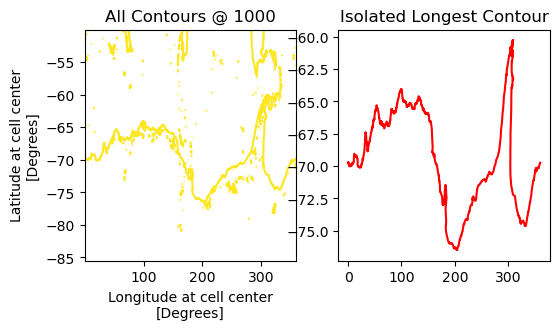

In [43]:
# obtain lon,lat boundaries for our domain of interest: 1000m isobath. 

bathym_on_uv = xr.open_dataset("bathym_on_uv.nc").bathymetry 
ds["deptho_on_uv"] = \
xr.DataArray(bathym_on_uv.values, dims=("YG", "XG")).ffill("XG").bfill("XG").ffill("YG").bfill("YG")


def iso_contour(da, level, figsize=(6, 3), imshow=True):
    """
    Return the longest contour line (x,y) for a single contour level.
    Works with xarray's .plot.contour across Matplotlib/xarray versions.
    """
    # Two panels only if we want to visualize
    if imshow:
        fig, ax = plt.subplots(ncols=2, figsize=figsize)
        ax0, ax1 = ax
    else:
        fig, ax0 = plt.subplots(ncols=1, figsize=figsize)
        ax1 = None

    # Draw the contour (single level)
    cs = da.plot.contour(ax=ax0, levels=[level], add_colorbar=False)
    ax0.set_title(f"All Contours @ {level}")

    # Get all segments at this (single) level
    # cs.allsegs is a list of levels; each item is a list of (N_i,2) arrays
    seglists = cs.allsegs
    if not seglists or not seglists[0]:
        plt.close(fig)
        raise ValueError(f"No contour segments found at level {level}.")

    # Choose the longest segment by number of vertices
    longest = max(seglists[0], key=lambda seg: seg.shape[0])
    xaxis_coords, yaxis_coords = longest[:, 0], longest[:, 1]

    if ax1 is not None:
        ax1.plot(xaxis_coords, yaxis_coords, 'r-', lw=1.5)
        ax1.set_title("Isolated Longest Contour")

    if not imshow:
        plt.close(fig)

    return xaxis_coords, yaxis_coords


# polygon coords 
x1000, y1000   = iso_contour(bathym_on_uv, 1000,  imshow=True)
print(x1000.shape,y1000.shape)



In [45]:

# Define regionate shelf polygon for evaluating heat flux convergence 
from xgcm import Grid

coords={'X': {'center': 'XC', 'left': 'XG'},
                        'Y': {'center': 'YC', 'left': 'YG'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds,coords=coords,boundary=boundary,autoparse_metadata=False)
grid


<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary='extend'):
  * center   YC --> left
  * left     YG --> center

In [46]:
ds_xouter = xr.concat([
    ds, ds.isel(XG=[0]).assign_coords({"XG":xr.DataArray(ds.XG.isel(XG=[0]).values + 360., dims=("XG",))})
], dim="XG", data_vars="minimal").rename({"XG":"XO"})
ds_xyouter = ds_xouter.isel(YC=slice(None, -1)).rename({"YG":"YO"})

geolon, geolat = xr.broadcast(ds_xyouter.XC, ds_xyouter.YC)
geolon_c, geolat_c = xr.broadcast(ds_xyouter.XO, ds_xyouter.YO)
ds_xyouter = ds_xyouter.assign_coords({"geolon":geolon, "geolat":geolat, "geolon_c":geolon_c, "geolat_c":geolat_c})

In [50]:
ds_xyouter

<xarray.Dataset> Size: 60GB
Dimensions:       (depth: 225, YC: 2540, XO: 8641, YO: 2541, XC: 8640)
Coordinates: (12/14)
    date          float32 4B 1.051e+06
  * depth         (depth) float32 900B -0.7 -2.117 ... -5.879e+03 -5.929e+03
  * XC            (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC           (XC) float32 35kB 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XO            (XO) float32 35kB 0.0 0.04167 0.08333 ... 359.9 360.0 360.0
    DXG           (XO) float32 35kB 363.5 363.5 363.5 ... 363.5 363.5 363.5
    ...            ...
  * YO            (YO) float32 10kB -85.5 -85.49 -85.48 ... -50.08 -50.05 -50.03
    DYG           (YO) float32 10kB 999.8 999.8 999.8 ... 2.975e+03 2.977e+03
    geolon        (XC, YC) float32 88MB 0.02083 0.02083 0.02083 ... 360.0 360.0
    geolat        (XC, YC) float32 88MB -85.5 -85.49 -85.48 ... -50.07 -50.04
    geolon_c      (XO, YO) float32 88MB 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0
    geolat_c      (XO, YO) float32 88MB -85.5 -85.49 -85.48 ... -50.05 -50.03
Data variables:
    UVEL          (depth, YC, XO) float32 20GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VVEL          (depth, YO, XC) float32 20GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    THETA         (depth, YC, XC) float32 20GB 7.606 7.607 ... 0.5653 0.6193
    deptho_on_uv  (YO, XO) float32 88MB 0.0 0.0 0.0 ... 3.669e+03 3.428e+03

In [51]:
# Define regionate shelf polygon for evaluating heat flux convergence 
from xgcm import Grid

coords={'X': {'center': 'XC', 'outer': 'XO'},
                        'Y': {'center': 'YC', 'outer': 'YO'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds_xyouter,coords=coords,boundary=boundary,autoparse_metadata=False)


In [52]:
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   XC --> outer
  * outer    XO --> center
Y Axis (not periodic, boundary='extend'):
  * center   YC --> outer
  * outer    YO --> center

In [53]:
# we want deptho on center points, not edge points 
ds_xyouter["deptho"] = grid.interp(grid.interp(ds_xyouter.deptho_on_uv, "X"), "Y")

In [ ]:
#name = "Antarctic margin"
#mask = (ds_xyouter.deptho <= 1000.) & (ds_xyouter.YC <= -60)
#region_dict = reg.MaskRegions(mask, grid).region_dict
#region = region_dict[0] # pick out the first region, corresponding to the longest contour
#region


ValueError: Dimensions {'yq', 'xq'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'XO': 8641, 'YO': 2541})

In [ ]:
# Make a region object by the "brute force" method 
region = reg.GriddedRegion(
    "AIS",
    x1000, 
    y1000,
    grid
)

In [ ]:
import pickle

with open('shelf_region.pkl', 'wb') as f:
    pickle.dump(region, f)